In [1]:
import cProfile
import pstats
import sys
from pstats import SortKey

import numpy as np
import pandas as pd
from river.decomposition import OnlineSVD, OnlineDMDwC
from river.preprocessing import Hankelizer
from river.utils import Rolling

Rolling.learn_one = Rolling.update
sys.path.append("../")

from functions.datasets import load_cats  # noqa: E402
from functions.chdsubid import SubIDChangeDetector  # noqa: E402
from functions.plot import plot_chd  # noqa: E402
from functions.preprocessing import hankel  # noqa: E402

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Read data
df = load_cats("data/cats/data_1t_agg_last.csv")
df.index = pd.to_datetime(df.index).tail(5000)
U = df[["aimp", "amud", "adbr", "adfl"]]
X = df[
    [
        "bed1",
        "bed2",
        "bfo1",
        "bfo2",
        "bso1",
        "bso2",
        "bso3",
        "ced1",
        "cfo1",
        "cso1",
    ]
]
Y_true = df.pop("y")
Y_cat = df.pop("category")

Processed 1000/20000

/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_59935/3572532125.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  modes[i, :, :] = odmd.modes
/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_59935/3572532125.py:72: ComplexWarning: Casting complex values to real discards the imaginary part
  dist[i, :] = subid_dmd.distances


Processed 19000/20000

/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_59935/3572532125.py:84: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


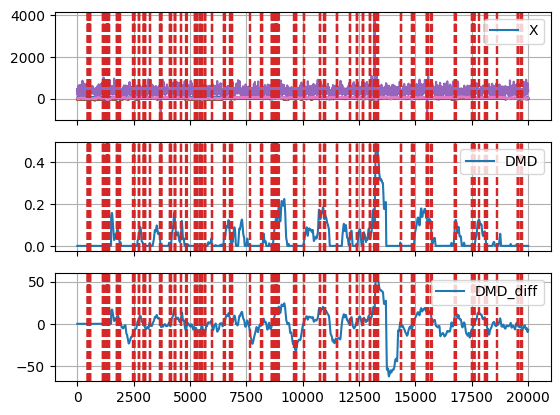

In [7]:
# TODO: enable hankelization of us on the fly
hu = 4
U_ = hankel(U, hn=hu)

# Initialize Hankelizer
hn = 40
hankelizer = Hankelizer(hn)

# Initialize Transformer
r = 6
init_size = 1000
odmd = Rolling(
    OnlineDMDwC(
        p=r,
        q=4,
        initialize=init_size,
        w=1.0,
        exponential_weighting=False,
        eig_rtol=1e-1,
    ),
    init_size + 1,
)
osvd = Rolling(
    OnlineSVD(
        n_components=r,
        initialize=init_size,
    ),
    init_size + 1,
)

# Initialize Change-Point Detector
ref_size = 500
test_size = 500
subid_dmd = SubIDChangeDetector(
    odmd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)
subid_svd = SubIDChangeDetector(
    osvd,
    ref_size=ref_size,
    test_size=test_size,
    grace_period=init_size + test_size + 1,
)

# Build pipeline
pipeline_dmd = hankelizer | subid_dmd
pipeline_svd = Hankelizer(hn) | subid_svd

# Prepare arrays for storing results
scores_dmd = np.zeros(X.shape[0], dtype=float)
scores_svd = np.zeros(X.shape[0], dtype=float)
scores_dmd_diff = np.zeros(X.shape[0], dtype=float)
dist = np.zeros((X.shape[0], 2), dtype=float)
modes = np.empty((X.shape[0], hn * X.shape[1], r), dtype=float)

# Run pipeline
for i, ((t, x), (t, u)) in enumerate(
    zip(
        X.iterrows(),
        U_.iterrows(),
    )
):
    # print every 1000
    if i % 1000 == 0:
        print(f"\rProcessed {i}/{len(X)}", end="")

    pipeline_dmd.learn_one(x.to_dict(), **{"u": u.to_dict()})
    # pipeline_svd.learn_one(x.to_dict())

    scores_dmd[i] = subid_dmd.score
    # scores_svd[i] = subid_svd.score
    if hasattr(subid_dmd.subid, "modes"):
        modes[i, :, :] = odmd.modes
        dist[i, :] = subid_dmd.distances

    scores_dmd_diff[i] = dist[i, 1] - dist[i, 0]

# Plot results
X_ = df.values
Y_ = Y_true.values
fig, axs = plot_chd(
    [X_, scores_dmd, scores_dmd_diff],
    np.where(Y_ == 1)[0],
    labels=["X", "DMD", "DMD_diff", "SVD"],
)

fig_name = (
    f"results/.cats/cats-chd_r{r}-"
    f"{f'roll_{odmd.window_size}' if isinstance(odmd, Rolling) else 'noroll'}-"
    f"dmd_w{odmd.w}-hx{hn}-hu{hu}-imag-corr.png"
)
fig.set_size_inches(18, 10)  # Set the size of the figure
fig.savefig(fig_name)

In [ ]:
def simulate():
    # Initialize Hankelizer
    hn = 80
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    r = 10
    init_size = 300
    odmd = Rolling(
        OnlineDMDwC(
            p=r,
            q=4,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )

    # Initialize Change-Point Detector
    ref_size = 200
    test_size = 200
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=init_size + test_size + 1,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    # Prepare arrays for storing results
    scores_dmd = np.zeros(X.shape[0], dtype=float)

    # Run pipeline
    for i, (_, x) in enumerate(df.iterrows()):
        # print every 1000
        if i % 1000 == 0:
            print(f"\rProcessed {i}/{len(df)}", end="")

        pipeline_dmd.learn_one(x.to_dict(), **{"u": u.to_dict()})

        scores_dmd[i] = subid_dmd.score


cProfile.run("simulate()", ".stats_new")

In [ ]:
p = pstats.Stats(".stats_new")
p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats()